# Correlation Downstream Analysis

### Story
SRA is hierarchically structured, with experiments (SRX) representing an individual library and runs (SRR) representing technical replicates of running a library on multiple lanes. It makes sense to collapse SRRs to the SRX level, but there is concern that sometimes SRRs within and SRX were are from separate libraries. To look for these types of relationships it makes sense to look at the correlation of SRRs within SRX and determine if they look like they are from the same library.

There are three classes of SRXs: (1) singletons which have only one SRR (n=13,456), (2) dubletons which have two SRRs (n=2,056), and (3) multi which have 3 or more SRRs per SRX (n=6,720). I also identified 170 runs that were missing their counts files. I need to go back and re-run these samples, but wanted to move on for now.

I have thought a lot about how to approach this problem. I think the method I have come up with is reasonable. I used a bootstrap approach to approximate and correlation cutoff. Briefly, using samples in the doubletons, I boostrapped 1,000 experiments each with ~1,000 random pairs of samples. I calculated the correlation between each of these samples and found the 95% correlation cutoff (i.e., the correlation value which 95% of random pairs fell below). I took the median from these 1,000 simulations and set a correlation cutoff of ~0.97. I think this number is conservative, because my original sample distribution was small enough that there are probably some real sample pairs in the the simulations. 

For doubletons, I looked for sample pairs that had correlations below the cutoff. I only kept the SRR with the largest library size. For multi, I compared each SRR (within SRX) to the median of the group. If the correlation was below the cutoff criteria I dropped the SRR. This could potentially remove excessive amounts of SRRs if there is one SRR that is very different and it drives the median further away from the other samples. It would probably be better to do some sort of iterative approach, but this still seems reasonable. Initially for the multi I was trying to use Mahalanobis distance instead, but could never get this to behave correctly.  

In general, most SRRs appeared to be highly correlated. I only ended up flagging 1,511 SRRs from 606 SRXs as having low correlations. 


### Output
* I have a file of flags located at `../../output/correlation_downstream_analysis.pkl`
    * `flag_missing_counts`: True if the counts file was missing.
    * `flag_singleton`: True if the SRX only had 1 SRR.
    * `flag_doubleton`: True if the SRX only had 2 SSRs.
    * `flag_multi`: True if the SRX had 3 or more SRRs.
    * `flag_drop_corr': True if correlation was below cutoff of 0.97

In [3]:
# %load ../config/defaults.py
# Load useful extensions

# Activate the autoreload extension for easy reloading of external packages
%reload_ext autoreload
%autoreload 2

# Trun on the water mark
%reload_ext watermark
%watermark -u -d -g

# Load ipycache extension
%reload_ext ipycache
from ipycache import CacheMagics
CacheMagics.cachedir = '../cachedir'

# Add project library to path
import sys
sys.path.insert(0, '../../lib/python')

# The usual suspects
import os
import numpy as np
import pandas as pd

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_context('poster')

# Turn off scientific notation
np.set_printoptions(precision=5, suppress=True)


last updated: 2017-10-10 
Git hash: 8c83e87b7c4eac097d2ea2f50eee0e3a81393eaa


In [4]:
# %load ../../bin/load.py
from pymongo import MongoClient
with open('/home/fearjm/Projects/ncbi_remap/output/.mongodb_host', 'r') as fh:
    host = fh.read().strip()
client = MongoClient(host=host, port=27022)
db = client['sra2']
remap = db['remap']

In [5]:
# imports
from itertools import combinations
from numpy.random import choice
from ncbi_remap.parser import parse_featureCounts_counts
from dask import delayed, compute
from dask import dataframe as dd
from dask.diagnostics import ProgressBar
from sklearn.neighbors import KernelDensity

In [6]:
# Constatns
PATTERN = '../../output/prealignment/raw/{srx}/{srr}/{srr}.hisat2.bam.feature_counts.counts'
IGNORE = []
CUTOFF = 0.97

In [7]:
# functions
def check_file(srx, srr):
    fname = PATTERN.format(srx=srx, srr=srr)
    return srx, srr, os.path.exists(fname)
    dfs.append(delayed(os.path.exists)(fname))
    
    
def read_data(srx, srr):
    fname = PATTERN.format(srx=srx, srr=srr)
    if os.path.exists(fname):
        return parse_featureCounts_counts(srr, fname).unstack(level=0)
    else:
        return None
    
    
# Create delayed pipeline for reading and calcuating corrs
def calc_corr(srx, srrs):
    curr = []
    for srr in srrs:
        curr.append(read_data(srx, srr))
    merged = pd.concat(curr, axis=1)
    return srx, merged.corr().iloc[0, 1], merged.sum().to_dict()


def calc_corr_multi(srx, srrs):
    curr = []
    for srr in srrs:
        curr.append(read_data(srx, srr))
        
    merged = pd.concat(curr, axis=1)
    med = merged.median(axis=1)
    return merged.apply(lambda x: {
        'srx': srx, 
        'srr': x.name, 
        'corr': stats.pearsonr(x, med)[0]
    }, axis=0).values.tolist()


def get_srr(x):
    srrs = x.srr_counts.keys()
    nsrr = len(srrs)
    return pd.DataFrame(list(zip([x.srx]*nsrr, srrs)), columns=['srx', 'verified_srr'])


def get_best_srr(x):
    best = max(x.srr_counts, key=lambda k: x.srr_counts[k])
    return pd.DataFrame([{'srx': x.srx, 'verified_srr': best}])
    
    
def get_files_for_group(df, func=calc_corr):
    dfs = []
    for srx, srrs in df.groupby('srx').aggregate({'srr': lambda x: x.tolist()}).iterrows():
        dfs.append(delayed(func)(srx, srrs[0]))
    return dfs

## How many SRXs have multiple SRRs?

The table below shows how many SRXs have multiple SRRs. The vast majority of SRXs have a single SRR. Very few SRXs have more than 3 SRRs. 

In [8]:
# Query db
agg = list(remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$match': {
            '$and': [
                {'runs.pre_aln_flags': {'$ne': 'download_bad'}},
                {'runs.pre_aln_flags': {'$ne': 'alignment_bad'}},
                {'runs.pre_aln_flags': {'$ne': 'quality_scores_bad'}},
                {'runs.pre_aln_flags': {'$ne': 'abi_solid'}},
                
            ]
        }
    },
    {'$unwind': '$runs.pre_aln_flags'},
    {
        '$group': {
            '_id': '$srx',
            'srrs': {'$addToSet': '$runs.srr'},
            'pre_aln_flags': {'$addToSet': '$runs.pre_aln_flags'}
        }
    },
    {
        '$match': {
            'pre_aln_flags': 'complete'
        }
    },
    {
        '$project': {
            '_id': 0,
            'srx': '$srx',
            'num_runs': {'$size': '$srrs'}
        }
    },
]))

df = pd.DataFrame(agg)

In [9]:
# summarize counts of SRRs per SRX
cnts = df.num_runs.value_counts().to_frame()
cnts.index.name = 'Number SRRs'
cnts.columns = ['Count']
cnts.applymap(lambda x: '{:,}'.format(x))

,Count
Number SRRs,
1,"13,456"
2,"1,027"
3,415
5,344
8,222
4,193
6,87
7,61
9,12


## Which SRRs are missing the files?

In [10]:
# Get a list of all complete and check that they have the files.
agg = remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$match': {
            '$and': [
                {'runs.pre_aln_flags': {'$ne': 'download_bad'}},
                {'runs.pre_aln_flags': {'$ne': 'alignment_bad'}},
                {'runs.pre_aln_flags': {'$ne': 'quality_scores_bad'}},
                {'runs.pre_aln_flags': {'$ne': 'abi_solid'}},
                
            ]
        }
    },
    {
        '$project': {
            '_id': 0,
            'srx': '$srx',
            'srr': '$runs.srr',
        }
    }
])

all_srr = pd.DataFrame(list(agg))

In [11]:
# Check and see if files are missing. 
dfs = []
for _, row in all_srr.iterrows():
    dfs.append(delayed(check_file)(row.srx, row.srr))

with ProgressBar():
    srr_chk_counts = pd.DataFrame(list(compute(*dfs)), columns=['srx', 'srr', 'flag_counts_exist'])

[########################################] | 100% Completed | 17.1s


In [12]:
# There are 10,632 files missing
srr_chk_counts.flag_counts_exist.value_counts().to_frame().applymap(lambda x: '{:,}'.format(x))

,flag_counts_exist
True,"22,189"
False,"10,632"


In [13]:
# IGNORE SRXs with missing files for now.
IGNORE = list(set(srr_chk_counts.loc[~srr_chk_counts.flag_counts_exist, 'srx'].tolist()))
#IGNORE.extend(['SRX1059356', ])

## What is the correlation like when there are 2 SRRs?

### Calculate correlation among SRRs within SRX.

This first approach just calculates SRRs within each SRX (with two SRRs). I then plot the distribution and see that the majority of samples have a correlation ≥.90, with only 65 SRXs with less than that.

The question is where to draw that cutoff. While .90 seems reasonable, perhaps a cutoff at .95 would be better. 

In [14]:
# Grab srx/srr where there are two srr per srx.
srxs = df.loc[df.num_runs == 2, 'srx'].values.tolist()

agg = remap.aggregate([
    {
        '$match': {
            '$and': [
                {'_id': {'$in': srxs}},
                {'_id': {'$nin': IGNORE}},
            ]
        }
    },
    {'$unwind': '$runs'},
    {
        '$match': {
            '$and': [
                {'runs.pre_aln_flags': {'$ne': 'download_bad'}},
                {'runs.pre_aln_flags': {'$ne': 'alignment_bad'}},
                {'runs.pre_aln_flags': {'$ne': 'quality_scores_bad'}},
                {'runs.pre_aln_flags': {'$ne': 'abi_solid'}},
                
            ]
        }
    },
    {
        '$project': {
            '_id': 0,
            'srx': '$srx',
            'srr': '$runs.srr',
        }
    }
])

twos = pd.DataFrame(list(agg))

In [15]:
# do all the computation
with ProgressBar():
    pair_srr_corr = compute(*get_files_for_group(twos))

[########################################] | 100% Completed |  3min  7.3s


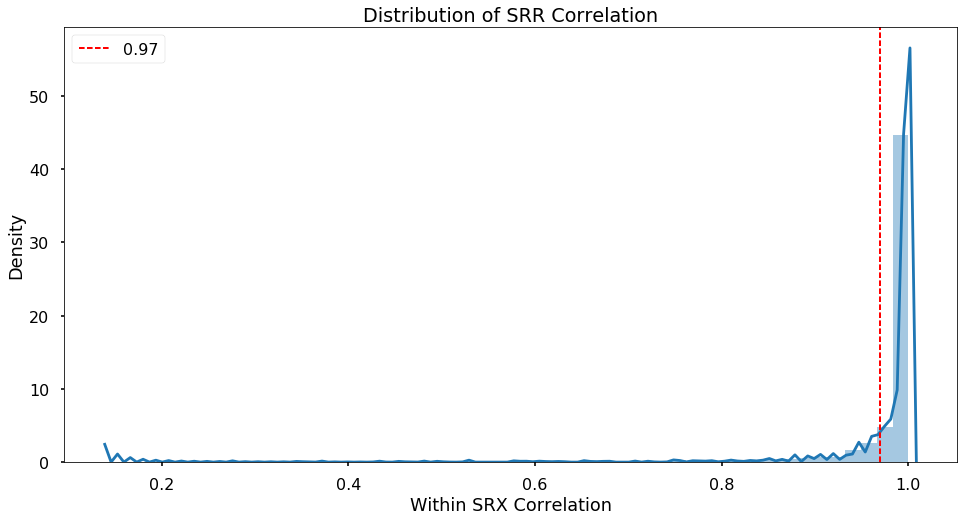

In [21]:
# Make table and plot results
fig, ax = plt.subplots(1, 1, figsize=plt.figaspect(1/2)*2)
df_corr = pd.DataFrame(list(pair_srr_corr), columns=['srx', 'corr', 'srr_counts'])
sns.distplot(df_corr['corr'], ax=ax)
ax.set_title('Distribution of SRR Correlation')
ax.set_xlabel('Within SRX Correlation')
ax.set_ylabel('Density');
ax.axvline(CUTOFF, color='red',  ls='--', lw=2, label='0.97');
ax.legend();

In [16]:
# print summary numbers
print('Total: {:,}'.format(df_corr.shape[0]))
print("""\
<0.9: {}
<.95: {}
<.98: {}
""".format((df_corr['corr'] < .90).sum(), (df_corr['corr'] < .95).sum(), (df_corr['corr'] < .98).sum()))

Total: 1,025
<0.9: 65
<.95: 121
<.98: 223



### Let's Bootstrap

In [17]:
# Create delayed pipeline for reading in coverage counts
dfs = []
for srx, srrs in twos.groupby('srx').aggregate({'srr': lambda x: x.tolist()}).iterrows():
    for srr in srrs[0]:
        dfs.append(delayed(read_data)(srx, srr))

In [18]:
# Compute to build dataframe
with ProgressBar():
    df_counts = dfs[0].compute()
    df_counts = df_counts.join(list(compute(*dfs[1:], num_workers=10)))

# Calculate pairwise correlation
all_corr = df_counts.corr()

[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  2min 58.5s


In [19]:
# Use a bootstrap type method to identify where the 95% cutoff for correlations should be.
def kde(data, corr_df, alpha=0.95):
    """Calculates KDE and then estimates correlation which 95% of samples are below.
    
    Parameters:
    -----------
    data: np.array
        Array of tuples with pairs of SRRs. The pairs of SRRs should be randomly put together.
    
    corr_df: pandas.DataFrame
        All pairwise correlations among all SRRs being examined.
        
    alpha: float < 1
        The cutoff to use to estimate correlation value that is larger than `alpha` * 100 samples.
    """
    # Pull out correlations
    corrs = []
    for first, second in data:
        corrs.append(corr_df.loc[first, second])

    # Fit emperical KDE
    kde_skl = KernelDensity(bandwidth=0.2)
    kde_skl.fit(np.asarray(corrs)[:, np.newaxis])
    
    # Calculate pdf on Grid
    x_grid = np.linspace(-1, 2, 1000)
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    
    # Integrate and find cutoff at alpha
    cum = np.cumsum(np.exp(log_pdf)) 
    return x_grid[np.argmax((cum / max(cum)) > alpha)]

# Figure out all possible combinations
all_possible_combos = np.array(list(combinations(twos.srr.tolist(), 2)))
idx = np.arange(0, len(all_possible_combos))

# Lets do some experiments
nexp = 1000                   # number of experiments to run
nobs = df_corr.shape[0]        # number of samples per experiment
experiments = all_possible_combos[choice(idx, size=(nexp, nobs)), :]

In [20]:
# Compute kde and cutoff loctions
random = [delayed(kde)(x, all_corr) for x in experiments]
with ProgressBar():
    random = compute(*random)

[########################################] | 100% Completed |  5min 44.4s


In [67]:
# output boostrap summary Make sure to change CUTOFF
print(
    'Using a correlation cutoff of {:0f}, '
    'I will combine 2 random samples by chance only 5% of the time'.format(np.median(random))
)

Using a correlation cutoff of 0.966967, I will combine 2 random samples by chance only 5% of the time


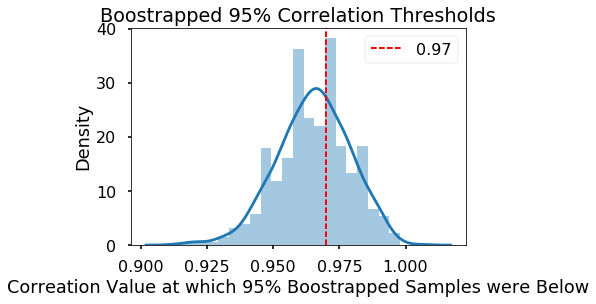

In [68]:
# Plot boostrap results
ax = sns.distplot(list(random))
ax.set_title('Boostrapped 95% Correlation Thresholds')
ax.axvline(CUTOFF, color='r', ls='--', lw=2, label='{:0.2f}'.format(CUTOFF));
ax.legend()
ax.set_xlabel('Correation Value at which 95% Boostrapped Samples were Below')
ax.set_ylabel('Density');

In [69]:
(df_corr['corr'] < CUTOFF).sum()

178

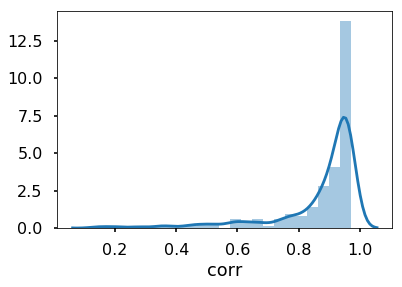

In [70]:
sns.distplot(df_corr.loc[(df_corr['corr'] < CUTOFF), 'corr'])

### Create table of SRX to SRR that can be merged

In [253]:
# If pair above cutoff then output both SRR, if pair less than cutoff only output the SRR with the most reads.
mask = df_corr['corr'] >= CUTOFF

dfs = []
for _, row in df_corr[mask].iterrows():
    dfs.append(get_srr(row))
    
for _, row in df_corr[~mask].iterrows():
    dfs.append(get_best_srr(row))
    
df_verified_pairs = pd.concat(dfs, ignore_index=True)

In [254]:
# check that I have not lost anything
assert df_verified_pairs.srx.nunique() == twos.srx.nunique()

## Now work with SRXs with more than 2 SRRs

In [7]:
# Grab srx/srr where there are more than srr per srx.
srxs = df.loc[df.num_runs > 2, 'srx'].values.tolist()

agg = remap.aggregate([
    {
        '$match': {
            '$and': [
                {'_id': {'$in': srxs}},
                {'_id': {'$nin': IGNORE}},
            ]
        }
    },
    {'$unwind': '$runs'},
    {
        '$match': {
            '$and': [
                {'runs.pre_aln_flags': {'$ne': 'download_bad'}},
                {'runs.pre_aln_flags': {'$ne': 'alignment_bad'}},
                {'runs.pre_aln_flags': {'$ne': 'quality_scores_bad'}},
                {'runs.pre_aln_flags': {'$ne': 'abi_solid'}},
                
            ]
        }
    },
    {
        '$project': {
            '_id': 0,
            'srx': '$srx',
            'srr': '$runs.srr',
        }
    }
])

multi = pd.DataFrame(list(agg))

In [188]:
# do all the computation
with ProgressBar():
    multi_srr_corr = compute(*get_files_for_group(multi, func=calc_corr_multi))

[########################################] | 100% Completed | 39min 26.0s


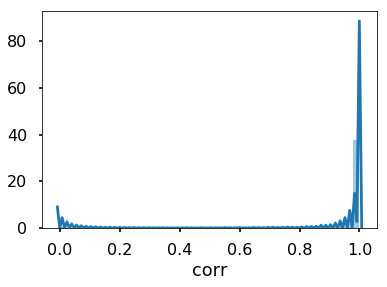

In [190]:
# Make table and plot results
df_multi_corr = pd.concat([pd.DataFrame(x) for x in multi_srr_corr])
sns.distplot(df_multi_corr['corr'])

In [200]:
print('There are {:,} runs that fall below our cutoff criteria.'.format((df_multi_corr['corr'] < CUTOFF).sum()))

There are 1,333 runs that fall below our cutoff criteria.


## Create Output Table

In [201]:
# Get list of singletons.
# Grab srx/srr where there are more than srr per srx.
srxs = df.loc[df.num_runs == 1, 'srx'].values.tolist()

agg = remap.aggregate([
    {
        '$match': {
            '$and': [
                {'_id': {'$in': srxs}},
                {'_id': {'$nin': IGNORE}},
            ]
        }
    },
    {'$unwind': '$runs'},
    {
        '$match': {
            '$and': [
                {'runs.pre_aln_flags': {'$ne': 'download_bad'}},
                {'runs.pre_aln_flags': {'$ne': 'alignment_bad'}},
                {'runs.pre_aln_flags': {'$ne': 'quality_scores_bad'}},
                {'runs.pre_aln_flags': {'$ne': 'abi_solid'}},
                
            ]
        }
    },
    {
        '$project': {
            '_id': 0,
            'srx': '$srx',
            'srr': '$runs.srr',
        }
    }
])

singles = pd.DataFrame(list(agg))

In [262]:
# Prep flags
singles['flag_singleton'] = True
singles['flag_drop_corr'] = False
singles['flag_missing_counts'] = False

twos['flag_doubleton'] = True
twos['flag_drop_corr'] = False
twos['flag_missing_counts'] = False

multi['flag_multi'] = True
multi['flag_drop_corr'] = False
multi['flag_missing_counts'] = False

# Update singles
## Flag singletons with missing files
singles.loc[singles.srx.isin(IGNORE), 'flag_missing_counts'] = True

# Update twos flags based on cutoffs
## Flag pairs with missing files
twos.loc[twos.srx.isin(IGNORE), 'flag_missing_counts'] = True

## Flag SRRs with low correlation
twos.loc[~twos.srr.isin(df_verified_pairs.verified_srr) & ~twos.flag_missing_counts, 'flag_drop_corr'] = True

# Update multi flags based on cutoffs
## Flag SRXs with missing files
multi.loc[multi.srx.isin(IGNORE), 'flag_missing_counts'] = True

## Flag SRRs with low correlation
srr_drop = df_multi_corr[df_multi_corr['corr'] < CUTOFF].srr
multi.loc[multi.srr.isin(srr_drop.values) & ~multi.flag_missing_counts, 'flag_drop_corr'] = True

# merge everything together
output = pd.concat([singles, twos, multi], ignore_index=True).fillna(False)

In [278]:
# Save output
cols = [
    'srx', 'srr', 'flag_missing_counts',
    'flag_singleton', 'flag_doubleton', 'flag_multi',
    'flag_drop_corr'
]
output[cols].set_index(['srx', 'srr']).to_pickle('../../output/correlation_downstream_analysis.pkl')

In [298]:
output.sum()

flag_doubleton                                                      2056
flag_drop_corr                                                      1511
flag_missing_counts                                                  170
flag_multi                                                          6720
flag_singleton                                                     13456
srr                    DRR001177DRR001178DRR001444DRR001445DRR001446D...
srx                    DRX000774DRX000775DRX000998DRX000999DRX001000D...
dtype: object

In [301]:
output.loc[output.flag_drop_corr, 'srx'].nunique()

606

In [304]:
df_corr.iloc[df_corr['corr'].argmin()]

srx                                                SRX043517
corr                                                0.147669
srr_counts    {'SRR103723': 29615181, 'SRR103724': 28138346}
Name: 377, dtype: object

In [305]:
df_corr[df_corr.srx == 'SRX043517']

,srx,corr,srr_counts
377,SRX043517,0.147669,"{'SRR103723': 29615181, 'SRR103724': 28138346}"
